In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

In [2]:
import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Импортируем функции из src
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

In [3]:
data = pd.read_csv('retail_train.csv')
item_features = pd.read_csv('product.csv')
user_features = pd.read_csv('hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [4]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [5]:
recommender = MainRecommender(data_train_lvl_1)

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?

In [10]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [11]:
# генерируем 50 кандидатов, используя similar_items_recommendation
result_lvl_1['similar_items'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, N=50))

In [12]:
result_lvl_1.head(4)

,user_id,actual,similar_items
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[825665, 840890, 8119134, 1036852, 1061747, 98..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[8090509, 5569845, 917816, 985999, 880888, 819..."
2,4,"[883932, 970760, 1035676, 1055863, 1097610, 67...","[944852, 7441210, 1011457, 892503, 995151, 100..."
3,6,"[1024306, 1102949, 6548453, 835394, 940804, 96...","[948650, 5569845, 890739, 941361, 983584, 1105..."


In [13]:
# генерируем 50 кандидатов, используя als
result_lvl_1['als'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=50))

In [14]:
result_lvl_1.head(4)

,user_id,actual,similar_items,als
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[825665, 840890, 8119134, 1036852, 1061747, 98...","[8090541, 5569374, 841584, 920200, 6533608, 80..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[8090509, 5569845, 917816, 985999, 880888, 819...","[916122, 1127831, 826835, 1004906, 866211, 992..."
2,4,"[883932, 970760, 1035676, 1055863, 1097610, 67...","[944852, 7441210, 1011457, 892503, 995151, 100...","[1121367, 910032, 863885, 906524, 1037387, 853..."
3,6,"[1024306, 1102949, 6548453, 835394, 940804, 96...","[948650, 5569845, 890739, 941361, 983584, 1105...","[1084036, 819840, 951834, 1026118, 6979393, 74..."


In [15]:
%%time
# генерируем 50 кандидатов, используя get_similar_users_recommendation
result_lvl_1['similar_users'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_users_recommendation(x, N=50))

Wall time: 7min 14s


In [16]:
result_lvl_1.head(4)

,user_id,actual,similar_items,als,similar_users
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[825665, 840890, 8119134, 1036852, 1061747, 98...","[8090541, 5569374, 841584, 920200, 6533608, 80...","[9677462, 1076247, 5570974, 5570513, 1016785, ..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[8090509, 5569845, 917816, 985999, 880888, 819...","[916122, 1127831, 826835, 1004906, 866211, 992...","[1098152, 1102250, 920528, 1062283, 1064752, 1..."
2,4,"[883932, 970760, 1035676, 1055863, 1097610, 67...","[944852, 7441210, 1011457, 892503, 995151, 100...","[1121367, 910032, 863885, 906524, 1037387, 853...","[944588, 905353, 1131384, 1021416, 871563, 825..."
3,6,"[1024306, 1102949, 6548453, 835394, 940804, 96...","[948650, 5569845, 890739, 941361, 983584, 1105...","[1084036, 819840, 951834, 1026118, 6979393, 74...","[1113675, 5995953, 7442505, 6979393, 853449, 7..."


In [19]:
# генерируем 50 кандидатов, используя own_recommendations
result_lvl_1['own'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))

In [20]:
result_lvl_1.head(4)

,user_id,actual,similar_items,als,similar_users,own
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[825665, 840890, 8119134, 1036852, 1061747, 98...","[8090541, 5569374, 841584, 920200, 6533608, 80...","[9677462, 1076247, 5570974, 5570513, 1016785, ...","[922281, 962967, 6514011, 9296837, 8090541, 10..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[8090509, 5569845, 917816, 985999, 880888, 819...","[916122, 1127831, 826835, 1004906, 866211, 992...","[1098152, 1102250, 920528, 1062283, 1064752, 1...","[976652, 988508, 5567582, 1131634, 945901, 927..."
2,4,"[883932, 970760, 1035676, 1055863, 1097610, 67...","[944852, 7441210, 1011457, 892503, 995151, 100...","[1121367, 910032, 863885, 906524, 1037387, 853...","[944588, 905353, 1131384, 1021416, 871563, 825...","[6391541, 936470, 939907, 9677093, 1121367, 10..."
3,6,"[1024306, 1102949, 6548453, 835394, 940804, 96...","[948650, 5569845, 890739, 941361, 983584, 1105...","[1084036, 819840, 951834, 1026118, 6979393, 74...","[1113675, 5995953, 7442505, 6979393, 853449, 7...","[12757544, 829685, 923600, 6979393, 880530, 99..."


In [22]:
# измеряем качество на data_val_lvl_1 с помощью recall@k
methods = ['similar_items', 'als', 'similar_users', 'own']
recall = dict()
for method in methods:
    recall[method] = result_lvl_1.apply(lambda row: recall_at_k(row[method], row['actual']), axis=1).mean()

recall

{'similar_items': 0.005610131974179749,
 'als': 0.009926919460015766,
 'similar_users': 0.0007393203113854158,
 'own': 0.009511956261990253}

Как и als метод own recommendtions дают лучшие значения recall@k.

In [25]:
%%time

params = [1, 5, 10, 50, 100, 200]

for param in params:
    result_lvl_1[f'als_{param}'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=param))

result_lvl_1.head(4)

Wall time: 1min 13s


,user_id,actual,similar_items,als,similar_users,own,als_20,als_50,als_100,als_200,als_500,als_1,als_5,als_10
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[825665, 840890, 8119134, 1036852, 1061747, 98...","[8090541, 5569374, 841584, 920200, 6533608, 80...","[9677462, 1076247, 5570974, 5570513, 1016785, ...","[922281, 962967, 6514011, 9296837, 8090541, 10...","[8090541, 5569374, 841584, 920200, 6533608, 80...","[8090541, 5569374, 841584, 920200, 6533608, 80...","[8090541, 5569374, 841584, 920200, 6533608, 80...","[8090541, 5569374, 841584, 920200, 6533608, 80...","[8090541, 5569374, 841584, 920200, 6533608, 80...",[8090541],"[8090541, 5569374, 841584, 920200, 6533608]","[8090541, 5569374, 841584, 920200, 6533608, 80..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[8090509, 5569845, 917816, 985999, 880888, 819...","[916122, 1127831, 826835, 1004906, 866211, 992...","[1098152, 1102250, 920528, 1062283, 1064752, 1...","[976652, 988508, 5567582, 1131634, 945901, 927...","[916122, 1127831, 826835, 1004906, 866211, 992...","[916122, 1127831, 826835, 1004906, 866211, 992...","[916122, 1127831, 826835, 1004906, 866211, 992...","[916122, 1127831, 826835, 1004906, 866211, 992...","[916122, 1127831, 826835, 1004906, 866211, 992...",[916122],"[916122, 1127831, 826835, 1004906, 866211]","[916122, 1127831, 826835, 1004906, 866211, 992..."
2,4,"[883932, 970760, 1035676, 1055863, 1097610, 67...","[944852, 7441210, 1011457, 892503, 995151, 100...","[1121367, 910032, 863885, 906524, 1037387, 853...","[944588, 905353, 1131384, 1021416, 871563, 825...","[6391541, 936470, 939907, 9677093, 1121367, 10...","[1121367, 910032, 863885, 906524, 1037387, 853...","[1121367, 910032, 863885, 906524, 1037387, 853...","[1121367, 910032, 863885, 906524, 1037387, 853...","[1121367, 910032, 863885, 906524, 1037387, 853...","[1121367, 910032, 863885, 906524, 1037387, 853...",[1121367],"[1121367, 910032, 863885, 906524, 1037387]","[1121367, 910032, 863885, 906524, 1037387, 853..."
3,6,"[1024306, 1102949, 6548453, 835394, 940804, 96...","[948650, 5569845, 890739, 941361, 983584, 1105...","[1084036, 819840, 951834, 1026118, 6979393, 74...","[1113675, 5995953, 7442505, 6979393, 853449, 7...","[12757544, 829685, 923600, 6979393, 880530, 99...","[1084036, 819840, 951834, 1026118, 6979393, 74...","[1084036, 819840, 951834, 1026118, 6979393, 74...","[1084036, 819840, 951834, 1026118, 6979393, 74...","[1084036, 819840, 951834, 1026118, 6979393, 74...","[1084036, 819840, 951834, 1026118, 6979393, 74...",[1084036],"[1084036, 819840, 951834, 1026118, 6979393]","[1084036, 819840, 951834, 1026118, 6979393, 74..."


In [26]:
recall = dict()
for param in params:
    recall[f'als_{param}'] = result_lvl_1.apply(lambda row: recall_at_k(row[f'als_{param}'], row['actual']), axis=1).mean()

recall

{'als_1': 0.0029556691012702606,
 'als_5': 0.009926919460015766,
 'als_10': 0.009926919460015766,
 'als_50': 0.009926919460015766,
 'als_100': 0.009926919460015766,
 'als_200': 0.009926919460015766}

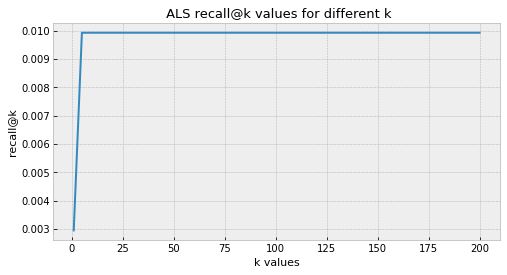

In [31]:
plt.figure(figsize=(8, 4))
with plt.style.context('bmh'):
    plt.plot(params, recall.values())
    plt.title(' ALS recall@k values for different k', fontsize=13)
    plt.xlabel('k values', fontsize=11)
    plt.ylabel('recall@k', fontsize=11)
    
plt.show()

При к>=5 значение recall@k не изменяется

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?